# **Deep Hedging**
# Buchkov Viacheslav

In [1]:
from pathlib import Path

from deep_hedging import ExperimentConfig, Forward, seed_everything
from deep_hedging.dl import SpotDataset, Trainer, Assessor
from deep_hedging.dl.models import LSTMHedger
from deep_hedging.dl.baselines import BaselineForward

RANDOM_SEED = 12

In [2]:
config = ExperimentConfig(
    RANDOM_SEED=RANDOM_SEED,
    DATA_ROOT=Path("data"),
    OUTPUT_ROOT=Path(".")
)
seed_everything(RANDOM_SEED)

config.DEVICE

device(type='mps')

In [3]:
config

ExperimentConfig(N_DAYS=5, REBAL_FREQ='30 min', VAR_QUANTILE=0.05, TEST_SIZE=0.1, RANDOM_SEED=12, DATA_ROOT=PosixPath('data'), OUTPUT_ROOT=PosixPath('.'), DATA_FILENAME='data_full', NORMALIZE=False, USE_TIME_DIFF=True, USE_SPOT_START=True, N_EPOCHS=20, LR=0.01, BATCH_SIZE=32, NUM_LAYERS=3, HIDDEN_DIM=32, OPTIMIZER=<class 'torch.optim.adam.Adam'>, NUM_WORKERS=2)

## Dataset.

In [4]:
spot_dataset = SpotDataset(
    n_days=config.N_DAYS,
    instrument_cls=Forward
)
spot_dataset.df.head()

,bid,ask,rub_rate,usd_rate,time_diff
timestamp,,,,,
2017-01-03 07:00:00+00:00,60.973760,61.016500,0.081265,0.00672,0.000000
2017-01-03 07:01:00+00:00,61.010855,61.068045,0.081265,0.00672,0.000002
2017-01-03 07:02:00+00:00,61.037220,61.069850,0.081265,0.00672,0.000004
2017-01-03 07:03:00+00:00,61.011955,61.048690,0.081265,0.00672,0.000006
2017-01-03 07:04:00+00:00,61.021250,61.052835,0.081265,0.00672,0.000008


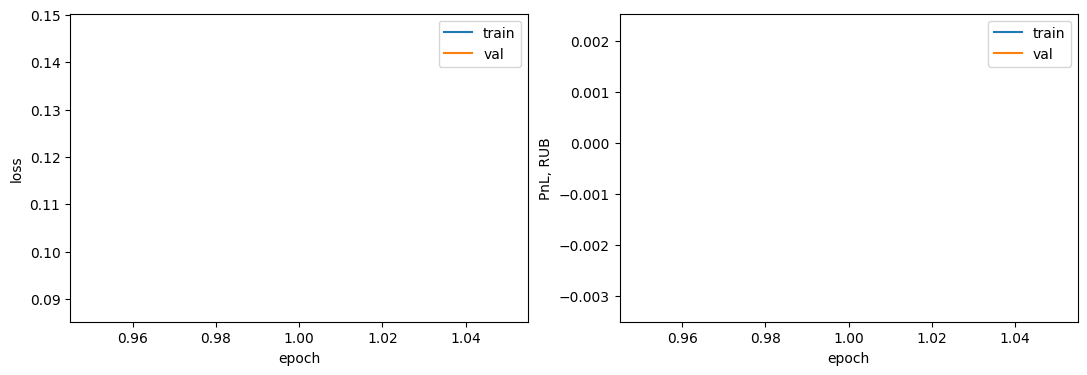

In [5]:
trainer = Trainer(
    model_cls=LSTMHedger,
    instrument_cls=Forward,
    config=config
)
trainer.run(1)

Average weight = -0.0917733907699585, Weights = [-0.09218291938304901; -0.08141006529331207]
Means: model = -0.103287, baseline = 0.144027
Stds: model = 1.675522, baseline = 0.195071
VaRs 5%: model = 3.105910, baseline = 0.125642
T-stat = -16.454075


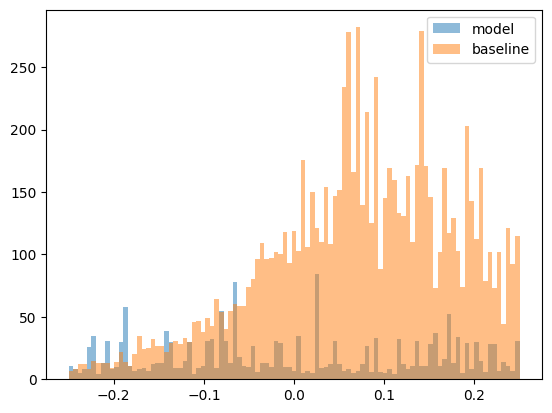

In [6]:
assessor = Assessor(
    model=trainer.hedger,
    baseline=BaselineForward(dt=trainer.dt).to(config.DEVICE),
    test_loader=trainer.test_loader
)
assessor.run()

In [7]:
trainer.save(config.OUTPUT_ROOT)